# Import libraries

In [ ]:
!pip install split-folders
import splitfolders
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
# from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Flatten, Dense

from sklearn.metrics import classification_report
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = ('/content/drive/MyDrive/Modul 5/rps')
folder_path

'/content/drive/MyDrive/Modul 5/rps'

# PRE-PROCESSING

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/Modul 5/rps', output="/content/drive/MyDrive/Modul 5/rps_split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # membagi dataset(train,val, test)


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  6.08 files/s]
Copying files: 2 files [00:00,  2.35 files/s]
Copying files: 3 files [00:00,  3.23 files/s]
Copying files: 4 files [00:01,  3.35 files/s]
Copying files: 5 files [00:01,  3.79 files/s]
Copying files: 6 files [00:01,  4.29 files/s]
Copying files: 7 files [00:01,  3.74 files/s]
Copying files: 8 files [00:21,  6.38s/ files]
Copying files: 9 files [00:21,  4.49s/ files]
Copying files: 14 files [00:21,  1.40s/ files]
Copying files: 17 files [00:21,  1.12 files/s]
Copying files: 23 files [00:22,  2.25 files/s]
Copying files: 30 files [00:22,  4.07 files/s]
Copying files: 39 files [00:22,  7.22 files/s]
Copying files: 46 files [00:22, 10.29 files/s]
Copying files: 52 files [00:22, 13.38 files/s]
Copying files: 59 files [00:22, 16.96 files/s]
Copying files: 64 files [00:22, 19.20 files/s]
Copying files: 70 files [00:22, 24.07 files/s]
Copying files: 75 files [00:23, 27.48 files/s]
Copying files: 80 files [0

# EDA

In [ ]:
# Definisikan path untuk data train dan data validation

base_dir = '/content/drive/MyDrive/Modul 5/rps_split'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Membuat visualisasi grid gambar secara acak dari setiap kelas dalam dataset

def plot_random_images(class_names, data_dir, num_images_per_class, figsize=(10, 10)):
    fig, ax = plt.subplots(len(class_names), num_images_per_class, figsize=figsize)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)


        for j in range(num_images_per_class):
            sample = random.choice(os.listdir(class_path))
            image = load_img(os.path.join(class_path, sample))

            ax[i, j].imshow(image)
            ax[i, j].set_title(class_name)
            # ax[i, j].axis("off")

    plt.show()

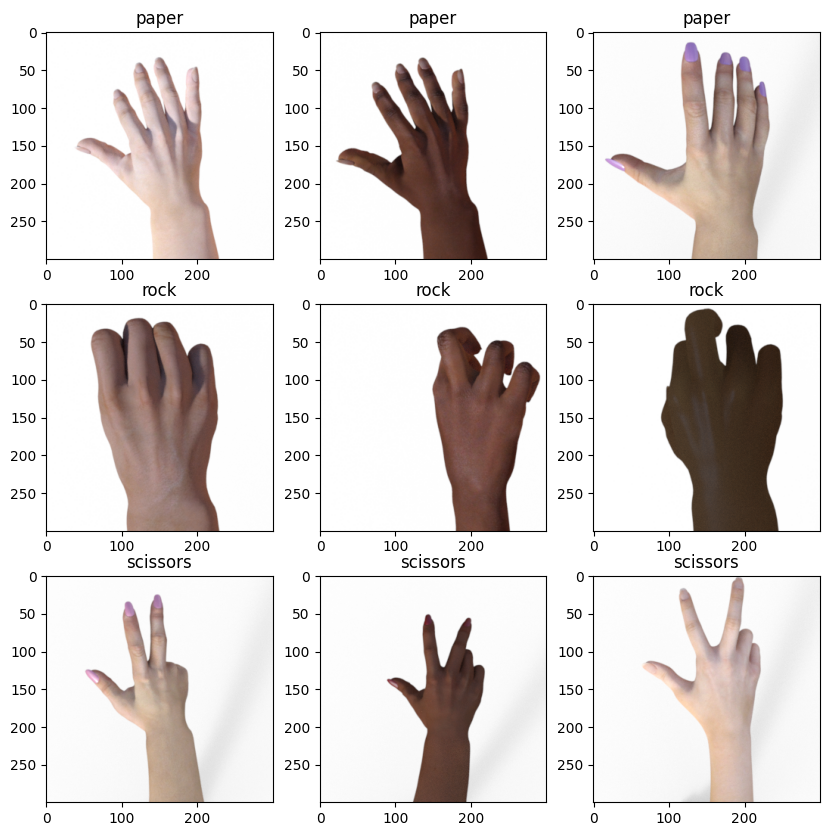

In [ ]:
classes = os.listdir(train_dir)
plot_random_images(classes, train_dir, len(classes))

# NLoad data using ImageDataGenerator()

In [ ]:
# Augmentasi data

#Parameter ini digunakan untuk mengubah nilai pixel sehingga berada dalam rentang 0 hingga 1
datagen = ImageDataGenerator(rescale = 1./255)

# Ini berfungsi untuk mendapatkan banyak variasi gambar yang lebih banyak sehingga dapat meningkatkam kinerja model
augmented_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=30,
                                       shear_range=0.2,
                                       zoom_range=0.025,
                                       horizontal_flip=True,
                                       brightness_range=(1,1.1),
                                       fill_mode='nearest')

In [ ]:
# Membuat data generator untuk train, validasi, dan test dari setiap kelas
IMG_SIZE = [128,128]
BATCH_SIZE = 64

train_dataset  = augmented_datagen.flow_from_directory(directory = train_dir,
                                             target_size = IMG_SIZE,
                                             class_mode = 'categorical',
                                             batch_size = BATCH_SIZE)

valid_dataset = datagen.flow_from_directory(directory = validation_dir,
                                            target_size = IMG_SIZE,
                                            class_mode = 'categorical',
                                            batch_size = BATCH_SIZE,
                                            shuffle=False)

test_dataset = datagen.flow_from_directory(directory = test_dir,
                                           target_size = IMG_SIZE,
                                           class_mode = 'categorical',
                                           batch_size = BATCH_SIZE,
                                           shuffle=False)

Found 1863 images belonging to 3 classes.
Found 232 images belonging to 3 classes.
Found 235 images belonging to 3 classes.


# Plot augmented images

In [ ]:
# Menampilkan beberapa gambar yang telah mengalami augmentasi dari tiap kelas
def plot_augmented_images(train_dataset, num_images_per_class=3, figsize=(10, 10)):

    # Get the class labels
    class_labels = list(train_dataset.class_indices.keys())

    # Adjust the image size by setting the figsize parameter
    fig, axes = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, class_label in enumerate(class_labels):
        # Get a batch of augmented images and labels for the current class
        images, labels = [], []
        while len(images) < num_images_per_class:
            batch_images, batch_labels = train_dataset.next()
            for j, label in enumerate(batch_labels):
                if np.argmax(label) == i:
                    images.append(batch_images[j])
                    labels.append(label)

        # Plot the augmented images for the current class
        for j in range(num_images_per_class):
            axes[i, j].imshow(images[j])
            axes[i, j].set_title(class_labels[np.argmax(labels[j])])
            axes[i, j].axis('off')

    plt.show()

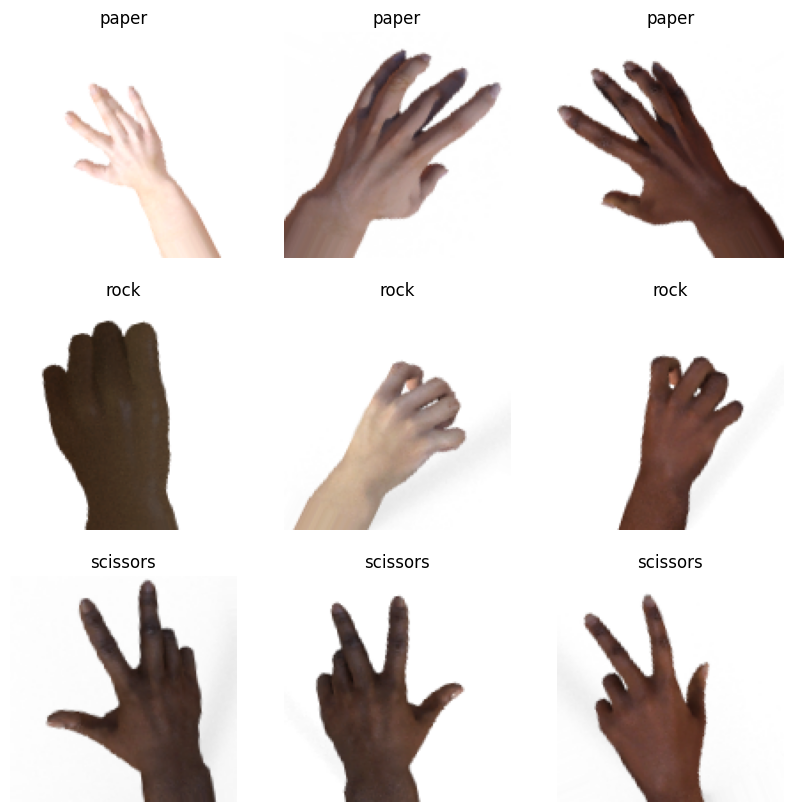

In [ ]:
plot_augmented_images(train_dataset)

# Transfer learning with VGG19

In [ ]:
# Membuat model jaringan saraf tiruan menggunakan arsitektur VGG19 (network surgery)
vgg = VGG19(weights='imagenet',
            input_shape=IMG_SIZE+[3],
            include_top=False)

for layer in vgg.layers:
    layer.trainable = False

# Define fully-connected layers
# Lapisan fully connected dilatih untuk menghasilkan prediksi berdasarkan fitur yang telah diekstraksi oleh VGG19
x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Ringkasan dari model VGG19
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Membersihkan semua state yang sudah tidak berfungsi (matrix, classification report)
tf.keras.backend.clear_session()

In [ ]:
# Mengompilasi dan melatih model menggunakan tensorflow
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=valid_dataset,
                    verbose=1)

Epoch 1/3
30/30 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.8637 

Copying files: 2520 files [23:55,  1.76 files/s]


30/30 [==============================] - 631s 21s/step - loss: 0.4442 - accuracy: 0.8637 - val_loss: 0.1377 - val_accuracy: 0.9741
Epoch 2/3
30/30 [==============================] - 614s 21s/step - loss: 0.0989 - accuracy: 0.9952 - val_loss: 0.0678 - val_accuracy: 0.9828
Epoch 3/3
30/30 [==============================] - 611s 20s/step - loss: 0.0612 - accuracy: 0.9962 - val_loss: 0.0420 - val_accuracy: 0.9871


# Model Evaluation

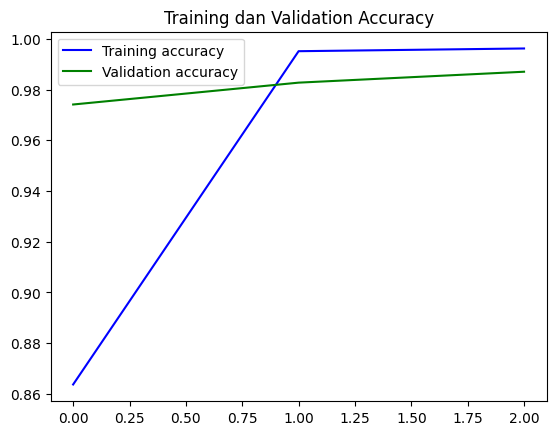

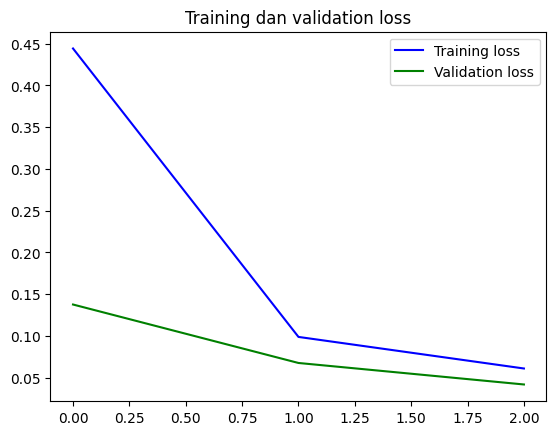

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training dan Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training dan validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
sns.set(style='whitegrid')

testLab = test_dataset.classes
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=-1)
class_names = test_dataset.class_indices

print(classification_report(y_pred, testLab, target_names=class_names))

4/4 [==============================] - 67s 16s/step
              precision    recall  f1-score   support

       paper       0.97      1.00      0.99        67
        rock       1.00      1.00      1.00        82
    scissors       1.00      0.98      0.99        86

    accuracy                           0.99       235
   macro avg       0.99      0.99      0.99       235
weighted avg       0.99      0.99      0.99       235



Image 1:
True Label: rock/rock07-k03-027.png
Predicted Label: rock



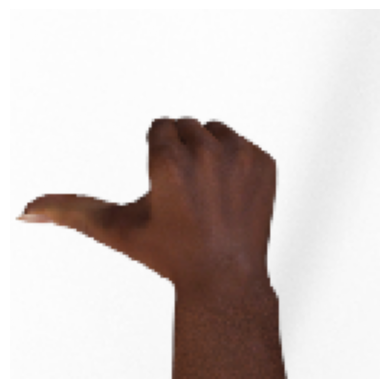

Image 2:
True Label: paper/paper06-101.png
Predicted Label: paper



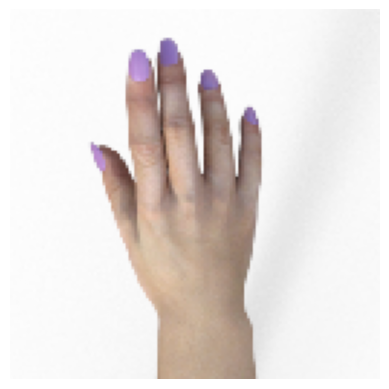

Image 3:
True Label: paper/paper07-093.png
Predicted Label: paper



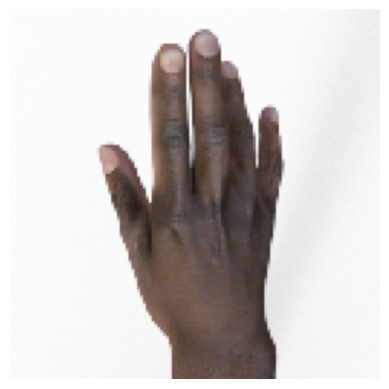

Image 4:
True Label: paper/paper01-046.png
Predicted Label: paper



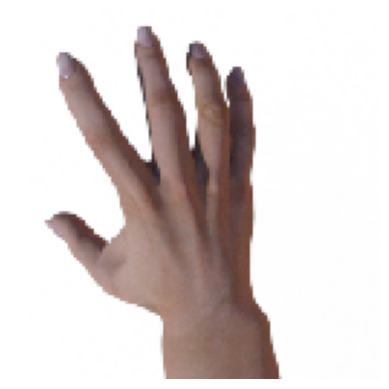

Image 5:
True Label: paper/paper07-060.png
Predicted Label: paper



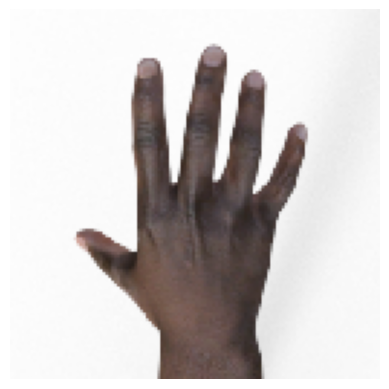

Image 6:
True Label: scissors/testscissors01-080.png
Predicted Label: scissors



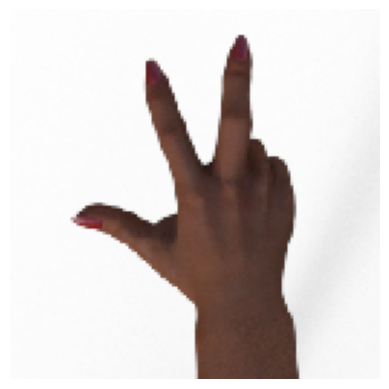

Image 7:
True Label: rock/rock04-111.png
Predicted Label: rock



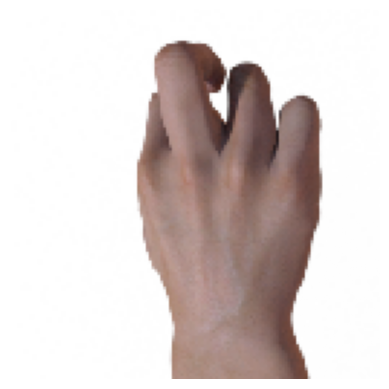

Image 8:
True Label: rock/rock06ck02-095.png
Predicted Label: rock



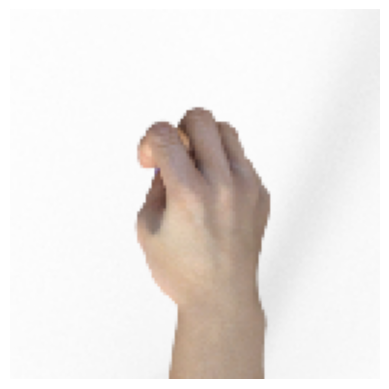

Image 9:
True Label: rock/rock01-111.png
Predicted Label: rock



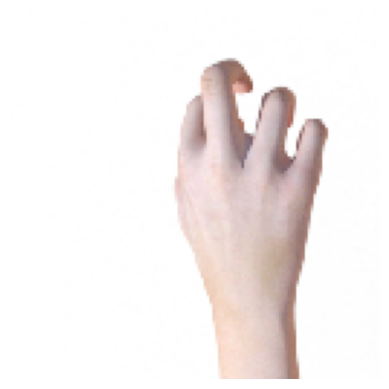

Image 10:
True Label: paper/paper01-064.png
Predicted Label: paper



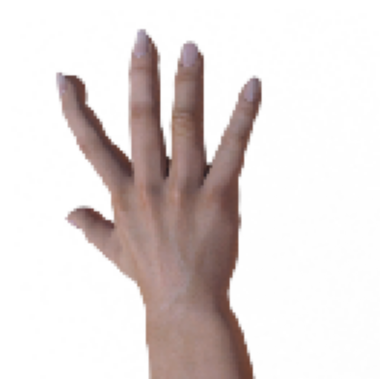

In [ ]:
# Membandingkan true label dan predicted label
predicted_label = [list(class_names.keys())[np.argmax(pred)] for pred in predictions]

# Get a list of 10 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset.filepaths)), 10)

# Iterate through the randomly selected indices
for i, index in enumerate(random_indices):
    image_path = test_dataset.filepaths[index]
    true_label = test_dataset.filenames[index]

    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = img / 255.0  # Normalize the image data

    print(f"Image {i+1}:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label[index]}\n")

    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [ ]:
model.save('model_rps.h5')